## Reconhecimento de Dígitos
### Alunos: 
Samila Ellen Garrido Rodrigues - 20210026788 <br>
Vladimir Yuri Farias de Lima Cavalcanti - 20190036575

### Introdução

O problema consiste em receber uma imagem de um número escrito a mão, codificada em tons de cinza, e classificar o dígito decimal usando dataset MNIST, utilizando os três modelos lineares de Aprendizagem de Máquina (AM) estudados: Perceptron, Regressão Linear e Regressão Logística.

### Importando as bibliotecas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from numpy import linalg as LA
from classificadores import *
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

### Intensidade

- Uma vez que os pixels mais escuros têm valores mais altos (com 255 representando o preto), é possível determinar a intensidade de uma imagem utilizando a seguinte equação que foi passada nos ensinamentos das aulas da disciplina.

$$ I = \frac{\sum_{x=0}^{783}𝑝𝑖𝑥𝑒𝑙x} {255} $$


In [2]:
def intensidade(img):
    return img.sum()/255

### Simetria

- A avaliação da simetria de uma imagem envolve a identificação dos eixos de simetria. Existem duas formas de simetria que podem ser facilmente calculadas: a simetria vertical e a simetria horizontal.

- Para calcular a simetria vertical, é necessário analisar cada linha individualmente. Em cada linha, é calculada a diferença absoluta entre o valor do pixel na primeira coluna e o valor na última coluna, na segunda coluna e na penúltima coluna, na terceira coluna e na antepenúltima coluna, e assim por diante. Se considerarmos a matriz de valores dos pixels da imagem como 𝑝𝑖𝑥28𝑥28, a equação correspondente é a seguinte:

$$ S_v = \frac{\sum_{i=0}^{27}\sum_{j=0}^{13} \left \| pix_{i,j} - pix_{i,27-j} \right \| }{255} $$

- A simetria horizontal segue um processo semelhante à simetria vertical, mas desta vez o eixo horizontal divide as linhas da matriz ao meio, criando duas partes: a parte superior e a parte inferior. Nesse caso, a diferença de valores entre os pixels é calculada de cima para baixo.

In [3]:
def simetria_vertical(img):
    img = np.array(img)
    img = img.reshape(28, 28)

    left_half = img[:, :14]
    right_half = img[:, 14:]

    symmetry_diff = np.abs(left_half - np.flip(right_half, axis=1))
    symmetry_score = np.sum(symmetry_diff) / 255

    return symmetry_score

- Logo, através de
algumas adaptações da equação da simetria vertical, é possível computar o $𝑆_h$ e, por fim,
somar ao $𝑆_𝑣$  e obter o valor de simetria da imagem completa.
Nesta atividade, deve-se construir novos arquivos de treino e teste a serem chamados
de train_redu.csv e test_redu.csv. Esses arquivos conterão 3 as seguintes colunas: label,
intensidade e simetria. 

In [4]:
def simetria_horizontal(img):
    img = np.array(img)
    img = img.reshape(28, 28)

    top_half = img[:14, :]
    bottom_half = img[14:, :]

    symmetry_diff = np.abs(top_half - np.flip(bottom_half, axis=0))
    symmetry_score = np.sum(symmetry_diff) / 255

    return symmetry_score

### Redução da dimensão das amostras

- Carrega os arquivos de treino e teste

In [5]:
df_train = pd.read_csv('dataset_digits/train.csv', sep=";")
df_test = pd.read_csv('dataset_digits/test.csv', sep=";")

- Aplica as funções de calculo de intensidade e simetria para a base de treino e de teste

In [6]:
df_train_reduzido = pd.DataFrame(df_train['label'].copy())
df_train.drop('label', axis=1, inplace=True)

df_train_reduzido['intensidade'] = df_train.apply(intensidade, axis=1)
df_train_reduzido['simetria_horizontal'] = df_train.apply(simetria_horizontal, axis=1)
df_train_reduzido['simetria_vertical'] = df_train.apply(simetria_vertical, axis=1)
df_train_reduzido['simetria'] = (df_train_reduzido['simetria_horizontal'] + df_train_reduzido['simetria_vertical'])

In [7]:
df_test_reduzido = pd.DataFrame(df_test['label'].copy())
df_test.drop('label', axis=1, inplace=True)

df_test_reduzido['intensidade'] = df_test.apply(intensidade, axis=1)
df_test_reduzido['simetria_horizontal'] = df_test.apply(simetria_horizontal, axis=1)
df_test_reduzido['simetria_vertical'] = df_test.apply(simetria_vertical, axis=1)
df_test_reduzido['simetria'] = (df_test_reduzido['simetria_vertical'] + df_test_reduzido['simetria_horizontal'])

- Exportando as bases de treino de de teste com os cálculos da intensidade e simetria de cada imagem. 

In [8]:
df_train_reduzido[['label', 'intensidade', 'simetria']].to_csv('dataset_digits/train_redu.csv', sep=';', index=False)
df_test_reduzido[['label', 'intensidade', 'simetria']].to_csv('dataset_digits/test_redu.csv', sep=';', index=False)

### Funções dos gráficos

In [9]:
def calculate_y(x, w):
    return -(w[0] + w[1] * x) / w[2]

def plot_alldigits(df, digits_list, title, ax=None, W=[]):

    colors = ['black', 'red', 'gray', 'blue']

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    else:
        fig = ax.get_figure()

    sns.set_style("darkgrid")
    sns.scatterplot(x='intensidade', y='simetria', hue='label', 
                data=df, palette=['black', 'orange', 'gray', 'blue'],
                marker='o', s=30, ax=ax)
    
    ax.set_xlabel('Intensidade', fontsize=14, fontweight='bold')
    ax.set_ylabel('Simetria', fontsize=14, fontweight='bold')
    ax.set_title(title, fontsize=16, fontweight='bold')

    ax.set_xlim([40, 200])
    ax.set_ylim([40, 200])

    if len(W) > 0:
        linestyles = ['dashed', 'dotted', 'dashdot', 'dotted']
        colors_w = ['purple', 'red', 'brown']
        for i, w in enumerate(W):
            x_values = np.array([df.intensidade.min(), df.intensidade.max()])
            y_values = calculate_y(x_values, w)
            ax.plot(x_values, y_values,
                    color=colors_w[i],
                    linestyle=linestyles[i],
                    label=f'Reta {digits_list[i]}x{digits_list[i+1:len(w)+1]}')
    
    return ax
            
def plot_1x5digits(df, digits_list, title, ax=None, W=[]):
     
    colors = ['red', 'blue']

    fig, ax = plt.subplots(figsize=(8, 6))

    sns.set_style("darkgrid")
    sns.scatterplot(x='intensidade', y='simetria', hue='label', 
                data=df, palette=['orange', 'blue'],
                marker='o', s=30)
    plt.xlabel('Intensidade', fontsize=14, fontweight='bold')
    plt.ylabel('Simetria', fontsize=14, fontweight='bold')
    plt.title(title, fontsize=16, fontweight='bold')

    plt.xticks(fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')

    plt.ylim(50, 150)

    if len(W) > 0:
        linestyles = ['dashed', 'dotted', 'dashdot', 'dotted']
        colors_w = ['red']
        for i, w in enumerate(W):
            x_values = np.array([df.intensidade.min(), df.intensidade.max()])
            y_values = calculate_y(x_values, w)
            ax.plot(x_values, y_values,
                    color=colors_w[i],
                    linestyle=linestyles[i],
                    label=f'Reta {digits_list[i]}x{digits_list[i+1:len(w)+1]}')

### Dados com as dimensões reduzidas

-  Base de treino reduzida

In [10]:
df_train = pd.read_csv("dataset_digits/train_redu.csv", sep=";")
df_train

,label,intensidade,simetria
0,0,145.435294,148.572549
1,0,118.576471,137.113725
2,0,127.600000,134.047059
3,0,138.047059,151.003922
4,0,146.215686,122.501961
...,...,...,...
2181,5,105.686275,133.890196
2182,5,113.050980,116.698039
2183,5,110.725490,133.019608
2184,5,99.305882,132.133333


#### Plot da base de treino dos dígitos 0, 1, 4 e 5 em um gráfico de dispersão pela Intensidade x Simetria.

<Axes: title={'center': 'Gráfico Train\nIntensidade x Simetria'}, xlabel='Intensidade', ylabel='Simetria'>

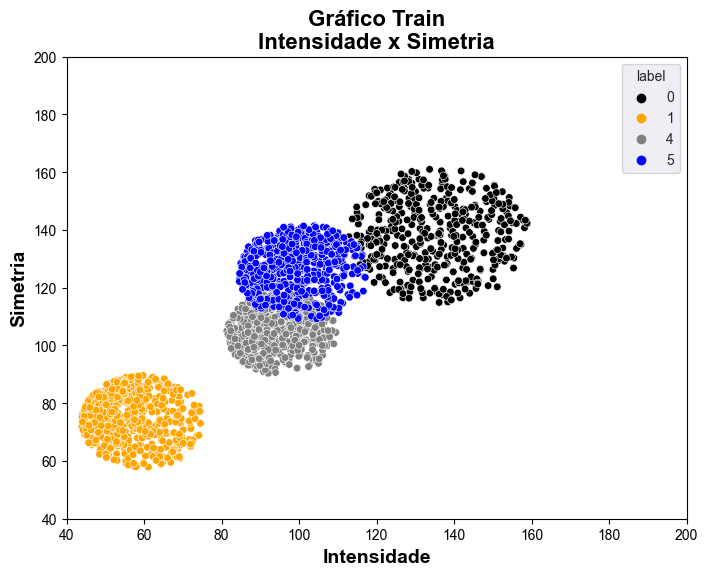

In [11]:
plot_alldigits(df_train, [0, 1, 4, 5], 'Gráfico Train\nIntensidade x Simetria')

#### CSV Teste Reduzido

In [12]:
df_test = pd.read_csv("dataset_digits/test_redu.csv", sep=';')
df_test

,label,intensidade,simetria
0,0,147.933333,130.470588
1,0,131.054902,122.721569
2,0,134.890196,151.725490
3,0,139.976471,133.921569
4,0,129.580392,130.274510
...,...,...,...
1110,5,96.121569,139.521569
1111,5,98.439216,130.729412
1112,5,95.141176,122.227451
1113,5,106.882353,128.007843


#### Plot da base de teste dos dígitos 0, 1, 4 e 5 em um gráfico de dispersão pela Intensidade x Simetria.x

<Axes: title={'center': 'Gráfico Test\nIntensidade x Simetria'}, xlabel='Intensidade', ylabel='Simetria'>

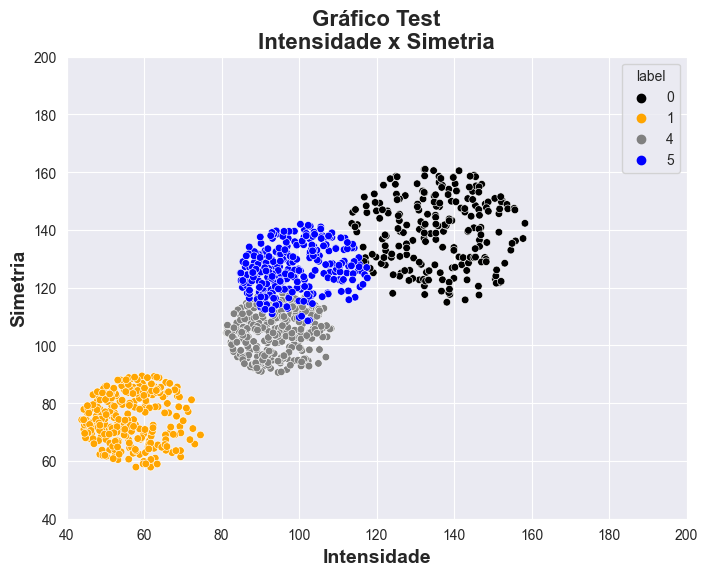

In [13]:
plot_alldigits(df_test, [0, 1, 4, 5], 'Gráfico Test\nIntensidade x Simetria')

## Classificação dos dígitos 1 x 5

- Importando os arquivos de treino (train_reduzido) e de teste (test_reduzido) para o classificador de dígitos 1 ou 5.

In [14]:
train_redu = pd.read_csv('dataset_digits/train_redu.csv', sep=';')
test_redu = pd.read_csv('dataset_digits/test_redu.csv', sep=';')

Filtra as imagens com label igual a 1 ou 5

In [15]:
label1 = train_redu.query("label==1")
label5 = train_redu.query("label==5")

label1_test = test_redu.query("label==1")
label5_test = test_redu.query("label==5")

In [16]:
train1x5 = pd.concat([label1, label5], axis=0).reset_index(drop=True)
test1x5 = pd.concat([label1_test, label5_test], axis=0).reset_index(drop=True)

- Plot de dispersão para ver a distribuição dos dígitos de acordo com sua intensidade e simetria.

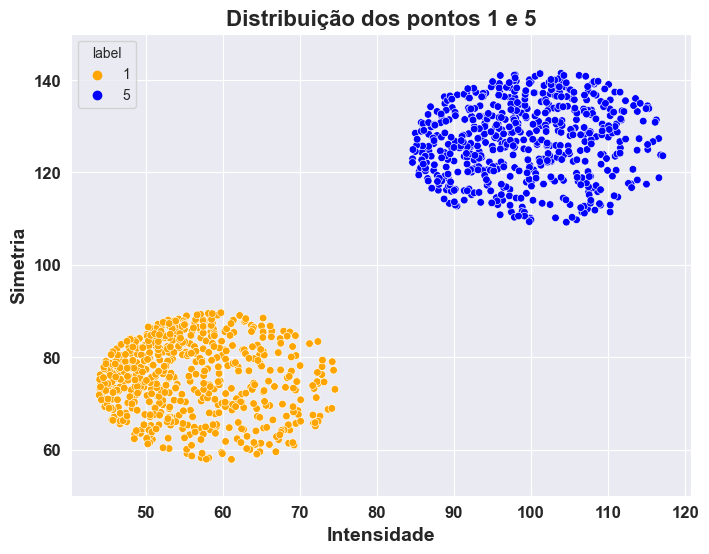

In [17]:
plot_1x5digits(train1x5, [1, 5], 'Distribuição dos pontos 1 e 5')

- Separando os dados, features das labels para poder passar para o treinamento.

In [18]:
X_train1x5 = train1x5.drop(columns=['label']).to_numpy()
X_train1x5 = np.c_[np.ones(X_train1x5.shape[0]), X_train1x5]

X_test1x5 = test1x5.drop(columns=['label']).to_numpy()
X_test1x5 = np.c_[np.ones(X_test1x5.shape[0]), X_test1x5]

# Determinando os valores para 1 e -1 para o treinamento dos dados utilizando os labels.
y_train1x5 = [1 if label == 1 else -1 for label in train1x5.label]
y_test1x5 = [1 if label == 1 else -1 for label in test1x5.label]

#### Perceptron (PLA) 1x5

- Utilizando o classificador do PLA completo para o treinamento.

In [19]:
# Determinando os valores do tamanho do treino e dos teste para passar para o classificador PLA Completo.
num_min = np.ceil(X_train1x5.shape[0] * 0.3).astype(int)
num_max = np.ceil(X_train1x5.shape[0] * 0.7).astype(int) 

# Criando a a classe PLA com o dados
pla = PLA(10_000, n_min=num_min, n_max=num_max)

# Aplicando o treinamento
pla.fit(X_train1x5, y_train1x5)


# Passando os dados de teste para o código determinar a sua classificação
y_pred_pla = pla.predict(X_test1x5)
w_pocket = pla.get_weights()

100%|██████████| 10000/10000 [01:02<00:00, 159.80it/s]


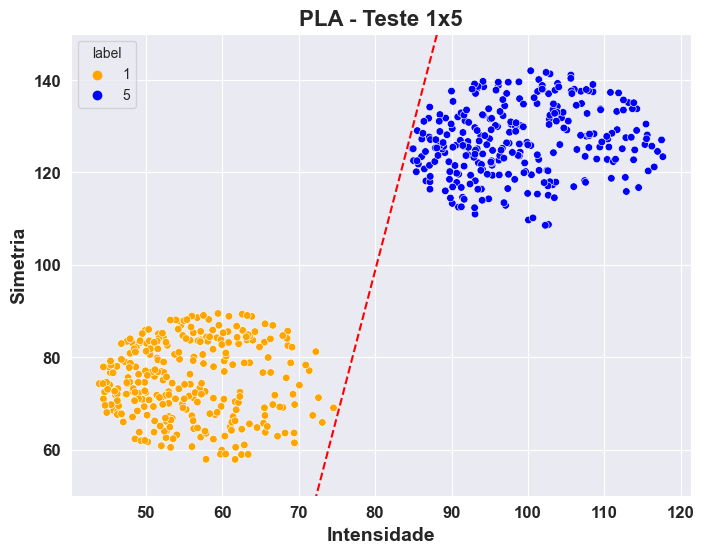

In [20]:
plot_1x5digits(test1x5, [1, 5], 'PLA - Teste 1x5', W=[w_pocket])

-  Matriz de Confusão e Métricas

In [21]:
def plot_metricas(test, pred, ax=None):

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    else:
        fig = ax.get_figure()

    print("\t \t    MÉTRICAS GERAIS: \n\n" + classification_report(test, pred))
    print("\n\t \t    Acurácia ->", round(accuracy_score(test, pred), 2))

    print("\n\n\t \t    MATRIZ DE CONFUSÃO: \n")
    sns.heatmap(confusion_matrix(test, pred), annot=True, ax=ax)

    return ax

	 	    MÉTRICAS GERAIS: 

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       291
           1       1.00      1.00      1.00       292

    accuracy                           1.00       583
   macro avg       1.00      1.00      1.00       583
weighted avg       1.00      1.00      1.00       583


	 	    Acurácia -> 1.0


	 	    MATRIZ DE CONFUSÃO: 



<Axes: >

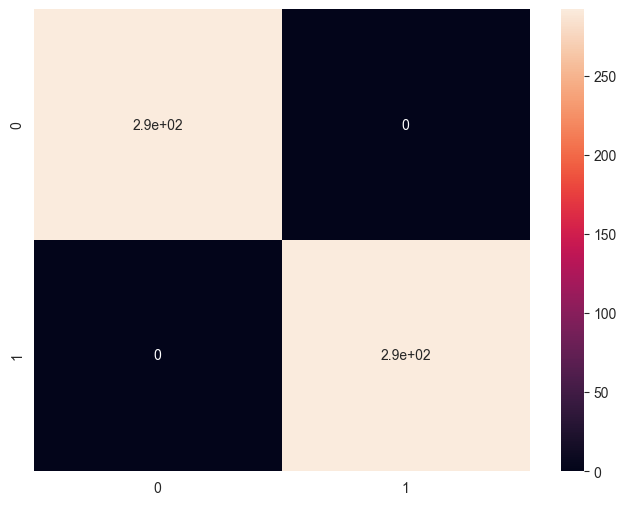

In [22]:
plot_metricas(y_test1x5, y_pred_pla)

#### Regressão Linear 1x5

In [23]:
# Criando váriavel com o modelo da Regressão Linear
regressao_linear = RegressaoLinear()

# Treinamento
regressao_linear.fit(X_train1x5, y_train1x5)

# Predição dos dados de teste
y_pred_rl = regressao_linear.predict(X_test1x5)

# Pegando os pesos
w_pesos = regressao_linear.get_weights()

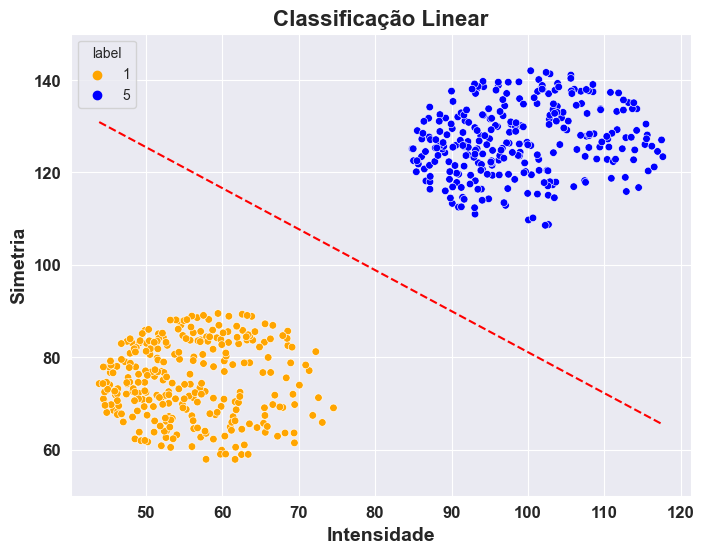

In [24]:
plot_1x5digits(test1x5, [1, 5], 'Classificação Linear', W=[w_pesos])

	 	    MÉTRICAS GERAIS: 

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       291
           1       1.00      1.00      1.00       292

    accuracy                           1.00       583
   macro avg       1.00      1.00      1.00       583
weighted avg       1.00      1.00      1.00       583


	 	    Acurácia -> 1.0


	 	    MATRIZ DE CONFUSÃO: 



<Axes: >

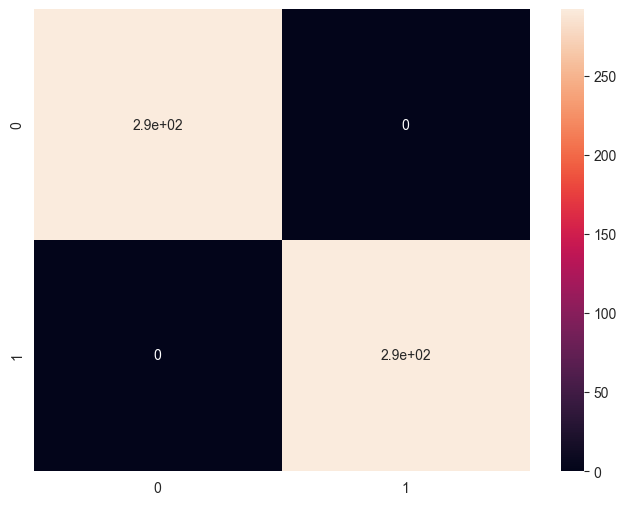

In [25]:
plot_metricas(y_test1x5, y_pred_rl)

#### Regressão Logística 1x5

In [26]:
# Criando variável com a função de Regressão Logística
regressao_logistica = RegressaoLogistica(iterador=80000, batch=512)

# Treinamento
regressao_logistica.fit(X_train1x5, y_train1x5)

# Predição dos dados de teste
y_pred_rlo = regressao_logistica.predict(X_test1x5)

# Pegando os pesos
logistic_pesos = regressao_logistica.get_weights()

  0%|          | 0/80000 [00:00<?, ?it/s]c:\Users\samila.rodrigues\Desktop\AM-Projeto1-Samila_Garrido-Vladimir_Yuri_v3\classificadores.py:113: RuntimeWarning: overflow encountered in exp
  sigm = 1 / (1 + np.exp(y_batch * np.dot(w, X_batch.T).reshape(-1, 1)))
100%|██████████| 80000/80000 [00:09<00:00, 8797.19it/s]


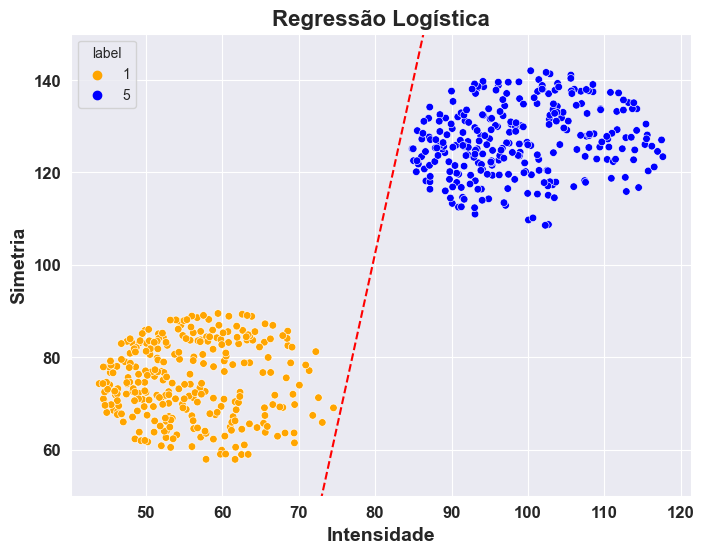

In [27]:
plot_1x5digits(test1x5, [1, 5], 'Regressão Logística', W=[logistic_pesos])

	 	    MÉTRICAS GERAIS: 

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       291
           1       1.00      1.00      1.00       292

    accuracy                           1.00       583
   macro avg       1.00      1.00      1.00       583
weighted avg       1.00      1.00      1.00       583


	 	    Acurácia -> 1.0


	 	    MATRIZ DE CONFUSÃO: 



<Axes: >

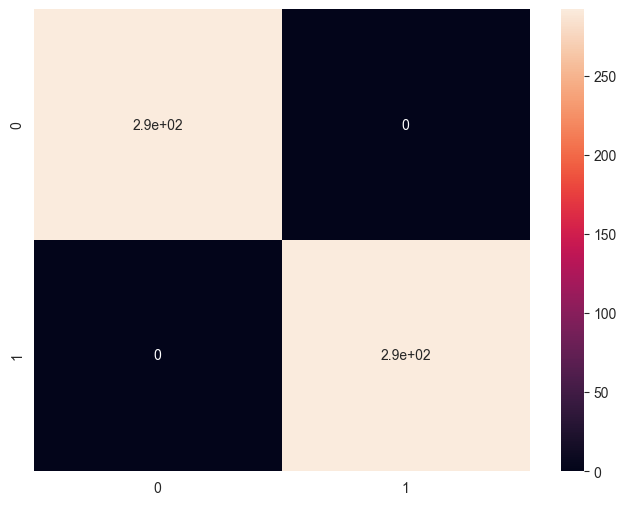

In [28]:
plot_metricas(y_test1x5, y_pred_rlo)

#

## One vs All

- Separando features das labels

In [29]:
# Separando features
X_train = df_train[['intensidade', 'simetria']].to_numpy()
X_train = np.c_[np.ones(X_train.shape[0]), X_train]

X_test = df_test[['intensidade', 'simetria']].to_numpy()
X_test = np.c_[np.ones(X_test.shape[0]), X_test]

# Separando labels
y_train = df_train['label'].to_numpy()
y_test = df_test['label'].to_numpy()

#### PLA - One vs All

In [30]:
# Determinando tamanho do conjunto de dados e de teste
n_min = np.ceil(X_train.shape[0] * 0.3).astype(int)
n_max = np.ceil(X_train.shape[0] * 0.7).astype(int) 

# Determinando o PLA
pla_oneall= PLA(20_000, n_min=n_min, n_max=n_max)

# Base de dígitos que serão usados no modelo
labels = [0, 1, 4, 5]

# Criando e treinando o modelo
model = OneVsAllClassifier(pla_oneall, labels)
model.fit(X_train, y_train)

# Pesos para criar os plots
pla_oneall_pesos = model.get_weights()

# Predição com a base de teste
y_pred_pla_oneall = model.predict(X_test)


100%|██████████| 20000/20000 [17:04<00:00, 19.53it/s]


<Axes: title={'center': 'PLA - One x All'}, xlabel='Intensidade', ylabel='Simetria'>

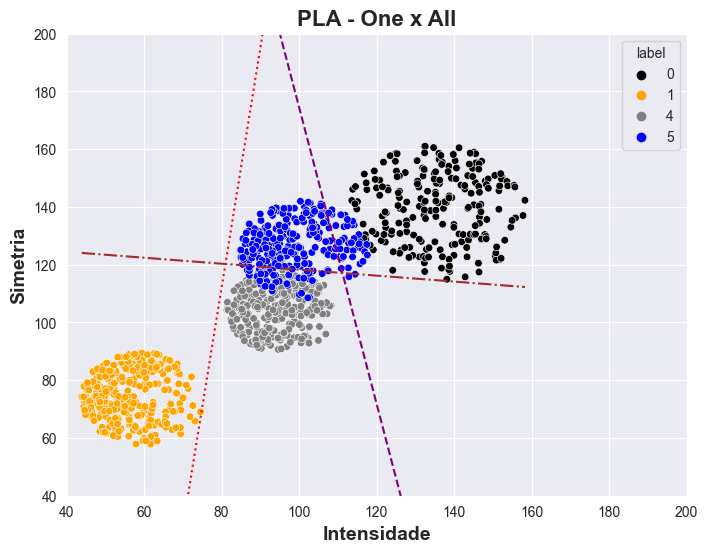

In [31]:
plot_alldigits(df_test, labels, 'PLA - One x All', W=pla_oneall_pesos[:4])

	 	    MÉTRICAS GERAIS: 

              precision    recall  f1-score   support

           0       0.83      1.00      0.91       218
           1       1.00      1.00      1.00       292
           4       0.88      1.00      0.94       314
           5       1.00      0.70      0.82       291

    accuracy                           0.92      1115
   macro avg       0.93      0.93      0.92      1115
weighted avg       0.93      0.92      0.92      1115


	 	    Acurácia -> 0.92


	 	    MATRIZ DE CONFUSÃO: 



<Axes: >

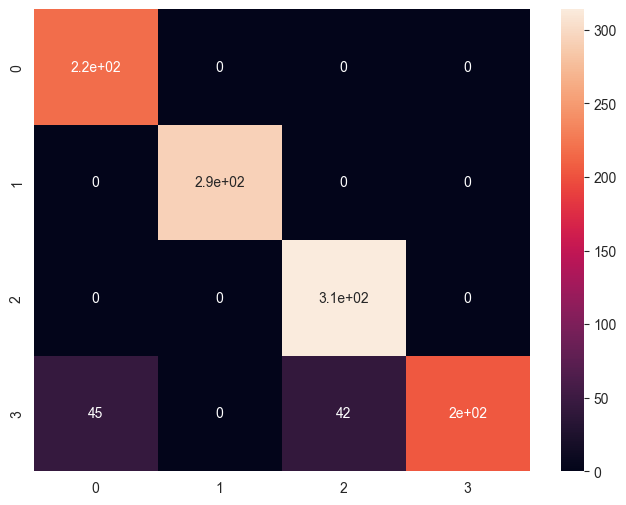

In [32]:
plot_metricas(y_test, y_pred_pla_oneall)

#### Regressão Linear - One vs all

In [33]:
# Criando a Classe com Regressão Linear
regressao_linear_oneall = RegressaoLinear()

# Dígitos que são classificados
labels = [0, 1, 4, 5]

# Criando variável do modelo e treinamento
modelo = OneVsAllClassifier(regressao_linear_oneall, labels)
modelo.fit(X_train, y_train)

# Captando os pesos
rl_oneall_pesos = modelo.get_weights()

# Predição com a base de teste
y_pred_rl_oneall = modelo.predict(X_test)

<Axes: title={'center': 'Regressão Linear - One vs All'}, xlabel='Intensidade', ylabel='Simetria'>

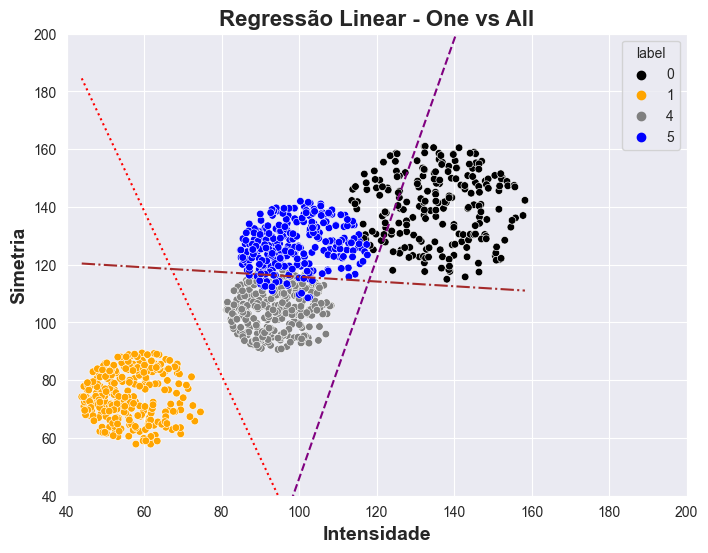

In [34]:
plot_alldigits(df_test, labels, 'Regressão Linear - One vs All', W=rl_oneall_pesos[:4])

	 	    MÉTRICAS GERAIS: 

              precision    recall  f1-score   support

           0       1.00      0.80      0.89       218
           1       1.00      1.00      1.00       292
           4       0.93      0.97      0.95       314
           5       0.84      0.92      0.88       291

    accuracy                           0.93      1115
   macro avg       0.94      0.92      0.93      1115
weighted avg       0.94      0.93      0.93      1115


	 	    Acurácia -> 0.93


	 	    MATRIZ DE CONFUSÃO: 



<Axes: >

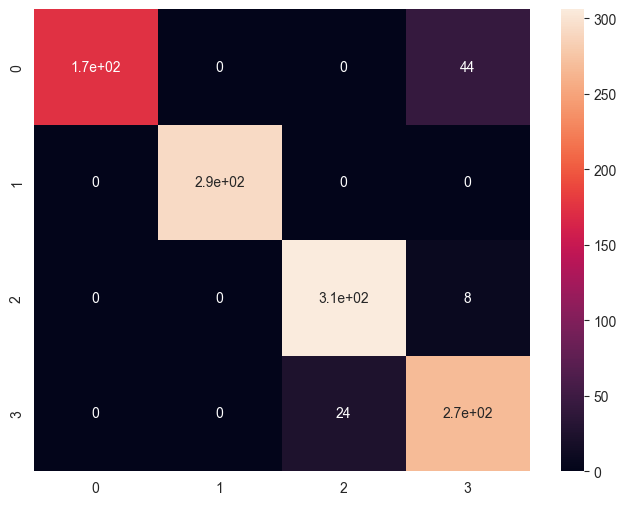

In [35]:
plot_metricas(y_test, y_pred_rl_oneall)

#### Regressão Logística - One vs all

In [36]:
# Dígitos a serem classificados
labels = [1, 0, 4, 5]

# Criando modelo com Regressão Logística
regressao_logistica_oneall = RegressaoLogistica(iterador=3_000_000, batch=256)

# Modelo e Treinamento
modelo = OneVsAllClassifier(regressao_logistica_oneall, labels)
modelo.fit(X_train, y_train)

# Pesos
rlo_oneall_pesos = modelo.get_weights()

# Predição com a base de teste
y_pred_rlo_oneall = modelo.predict(X_test)

  0%|          | 0/3000000 [00:00<?, ?it/s]c:\Users\samila.rodrigues\Desktop\AM-Projeto1-Samila_Garrido-Vladimir_Yuri_v3\classificadores.py:113: RuntimeWarning: overflow encountered in exp
  sigm = 1 / (1 + np.exp(y_batch * np.dot(w, X_batch.T).reshape(-1, 1)))
100%|██████████| 3000000/3000000 [04:15<00:00, 11729.75it/s]


<Axes: title={'center': 'Regressão Logística - One vs All'}, xlabel='Intensidade', ylabel='Simetria'>

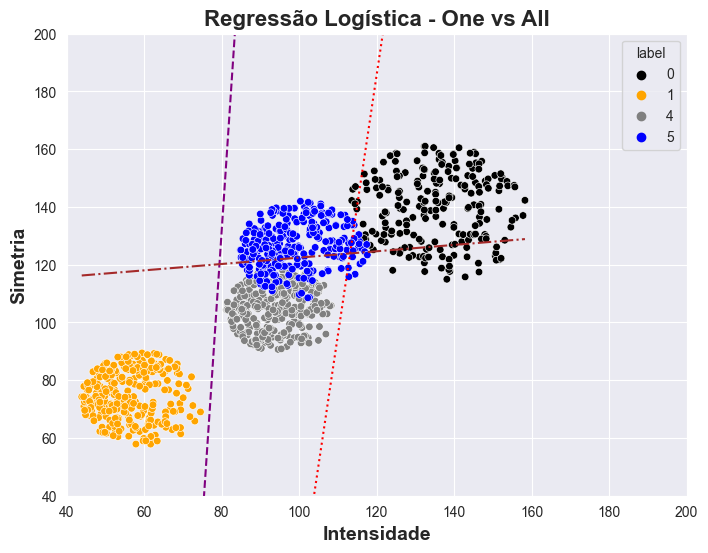

In [37]:
plot_alldigits(df_test, labels, 'Regressão Logística - One vs All', W=rlo_oneall_pesos[:4])

	 	    MÉTRICAS GERAIS: 

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       218
           1       1.00      1.00      1.00       292
           4       0.81      1.00      0.90       314
           5       0.97      0.70      0.81       291

    accuracy                           0.92      1115
   macro avg       0.93      0.92      0.91      1115
weighted avg       0.93      0.92      0.91      1115


	 	    Acurácia -> 0.92


	 	    MATRIZ DE CONFUSÃO: 



<Axes: >

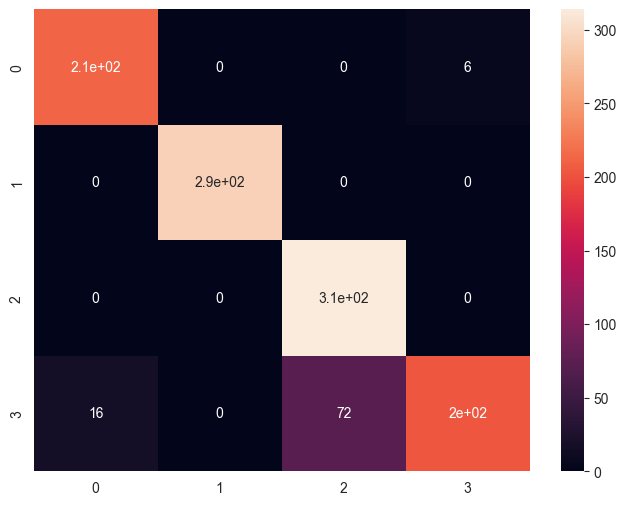

In [38]:
plot_metricas(y_test, y_pred_rlo_oneall)

### Comparação dos modelos

- Comparação dos modelos por gráfico dos modelos lineares de treinamento.

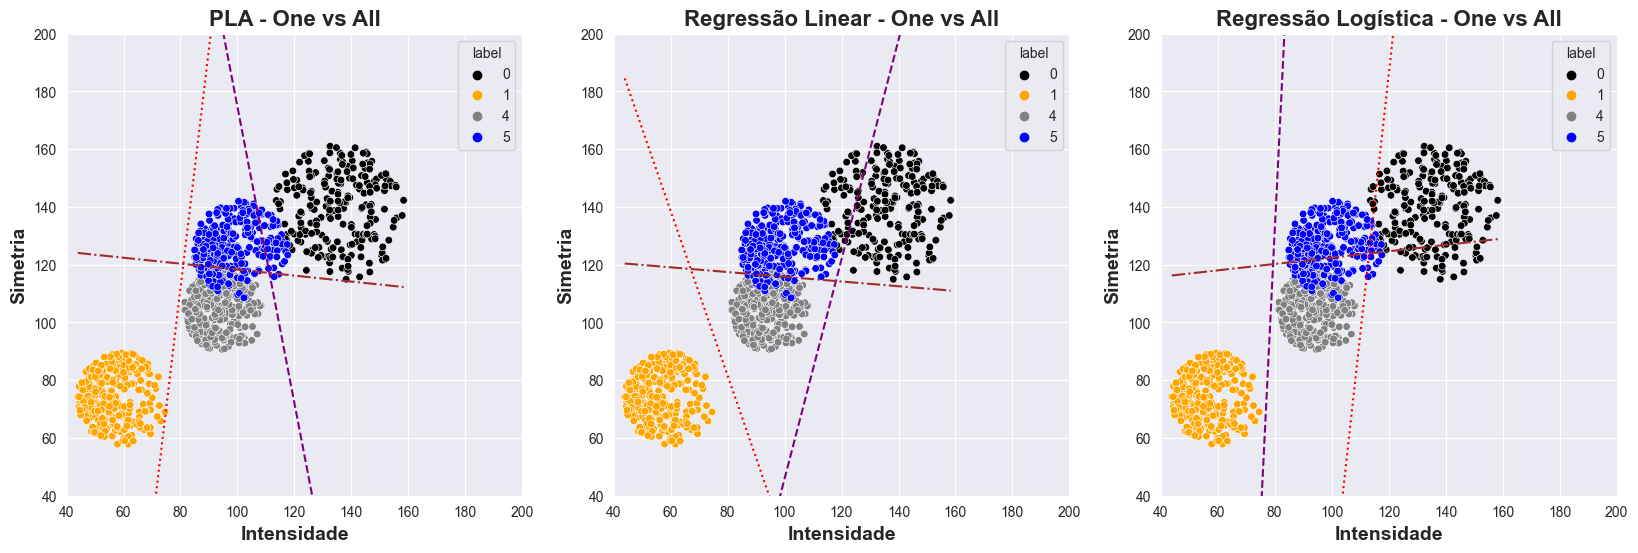

In [39]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
plot_alldigits(df_test, labels, 'PLA - One vs All', W=pla_oneall_pesos[:4], ax=axs[0])
plot_alldigits(df_test, labels, 'Regressão Linear - One vs All', W=rl_oneall_pesos[:4], ax=axs[1])
plot_alldigits(df_test, labels, 'Regressão Logística - One vs All', W=rlo_oneall_pesos[:4], ax=axs[2]);

- Comparação dos modelos por gráfico da matriz de confusão e acurácia

In [40]:
def plot_matrizes(test, pred, ax=None):

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    sns.heatmap(confusion_matrix(test, pred), annot=True, ax=ax)
    ax.set_title("Acurácia -> " + str(round(accuracy_score(list(test), list(pred)), 2)), size=15)

    return ax

- Respectivamente PLA - REGRESSÃO LINEAR - REGRESSÃO LOGÍSTICA

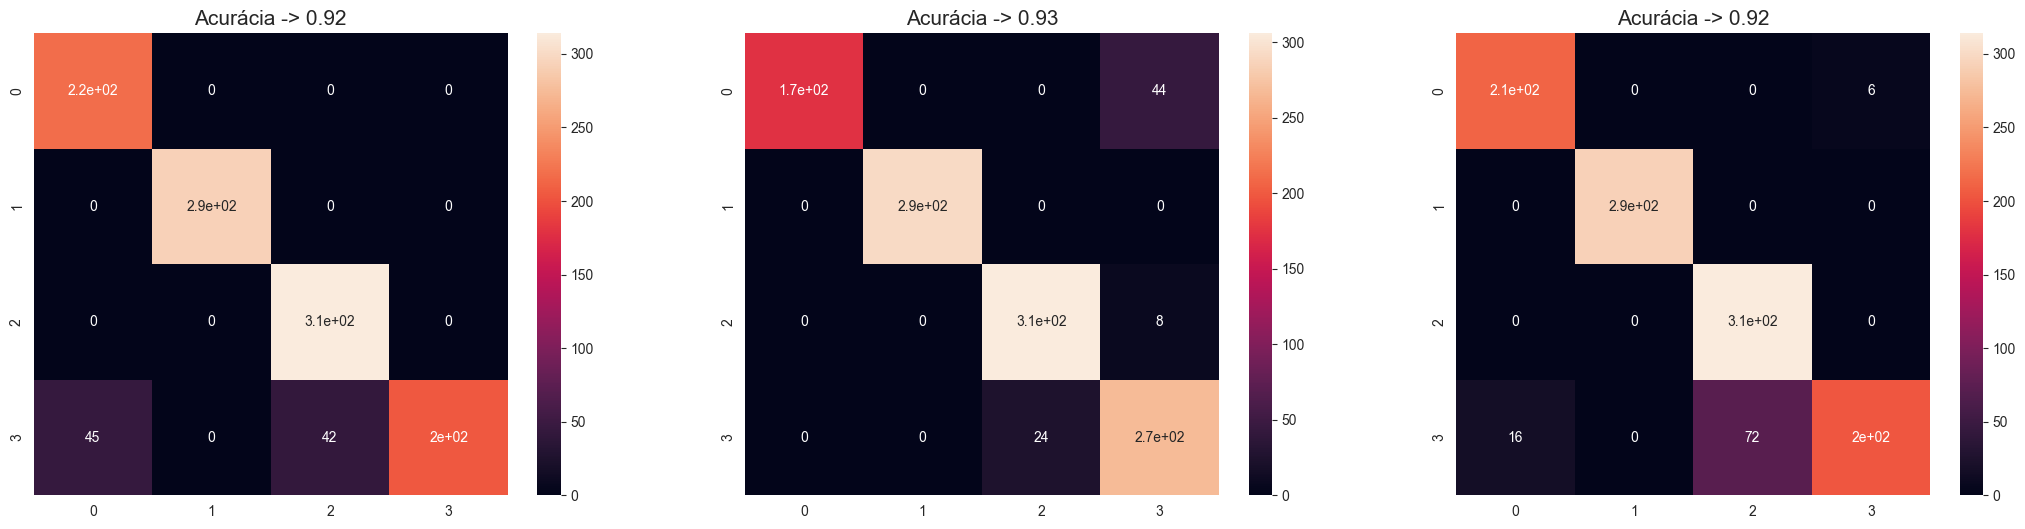

In [41]:
fig, axs = plt.subplots(1, 3, figsize=(26, 6))

plot_matrizes(y_test, y_pred_pla_oneall, ax=axs[0])
plot_matrizes(y_test, y_pred_rl_oneall, ax=axs[1])
plot_matrizes(y_test, y_pred_rlo_oneall, ax=axs[2])

plt.show()